# **Lab08: Bag of Visual Words**

In [0]:
# Import Statements
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [0]:
# Load Data
def load_data(path):
  image_list = {}
  count = 0

  for word in os.listdir(path):
    image_list[word] = []
    for image_file in os.listdir(path + "/" + word):
      image = cv2.imread(path + "/" + word + "/" + image_file, 0)
      image_list[word].append(image)
      count += 1

  return image_list, count

# Load train and test data
train_dict, train_count = load_data("images/train")
test_dict, test_count = load_data("images/test")

In [5]:
train_dict, train_count, test_dict, test_count

({'Soccer_Ball': [array([[179, 200, 200, ..., 203, 209, 191],
          [209, 206, 189, ..., 179, 178, 213],
          [219, 173, 199, ..., 197, 199, 214],
          ...,
          [207, 207, 211, ..., 195, 195, 194],
          [187, 191, 191, ..., 198, 196, 195],
          [193, 211, 195, ..., 194, 194, 193]], dtype=uint8),
   array([[255, 255, 255, ..., 255, 255, 255],
          [255, 255, 255, ..., 255, 255, 255],
          [255, 255, 255, ..., 255, 255, 255],
          ...,
          [255, 255, 255, ..., 254, 254, 254],
          [255, 255, 255, ..., 254, 254, 254],
          [255, 255, 255, ..., 255, 255, 255]], dtype=uint8),
   array([[170, 170, 170, ..., 176, 176, 175],
          [170, 170, 170, ..., 174, 174, 174],
          [170, 170, 170, ..., 172, 172, 173],
          ...,
          [ 31,  34,  34, ...,  78, 101, 114],
          [ 31,  31,  29, ...,  80, 106, 121],
          [ 25,  28,  30, ...,  80, 105, 120]], dtype=uint8),
   array([[126, 104,  79, ...,  83,  79,  74],
  

In [8]:
# Word to Numbers Mappings
word_to_id = {}
for word, _ in train_dict.items():
  word_to_id[word] = len(word_to_id)

word_to_id

{'Soccer_Ball': 3, 'accordion': 1, 'dollar_bill': 0, 'motorbike': 2}

In [9]:
# Map numbers back to Words
id_to_word = { v:k for k,v in word_to_id.items()}
id_to_word

{0: 'dollar_bill', 1: 'accordion', 2: 'motorbike', 3: 'Soccer_Ball'}

In [17]:
# Extract SIFT features
train_descriptors_list = []
train_labels = []
sift = cv2.xfeatures2d.SIFT_create()

for word, image_list in train_dict.items():
  for image in image_list:
    train_labels.append(word_to_id[word])
    keypoints, descriptors = sift.detectAndCompute(image, None)
    train_descriptors_list.append(descriptors)

len(train_descriptors_list), len(train_labels)

(56, 56)

In [18]:
def formatND(l):
  vStack = np.array(l[0])
  for remaining in l[1:]:
    vStack = np.vstack((vStack, remaining))
  return vStack

train_descriptors = formatND(train_descriptors_list)
train_descriptors.shape

(25084, 128)

In [0]:
# Perform Clustering
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 20)
kmeans_ret = kmeans.fit_predict(train_descriptors)

In [0]:
# Create Vocabulary
def vocabulary(n_images, descriptor_list, kmeans_ret):
  vocab_hist = np.array([np.zeros(20) for i in range(n_images)])
  count = 0

  for i in range(n_images):
    d_len = len(descriptor_list[i])
    for j in range(d_len):
      idx = kmeans_ret[count + j]
      vocab_hist[i][idx] += 1
    count += 1

  return vocab_hist

train_vocab_hist = vocabulary(train_count, train_descriptors_list, kmeans_ret)

[2368 1673  898  510  668 1444  575 1592 1226 1354  864 2160 1036 1624
  994  749  827 2527 1278  717]


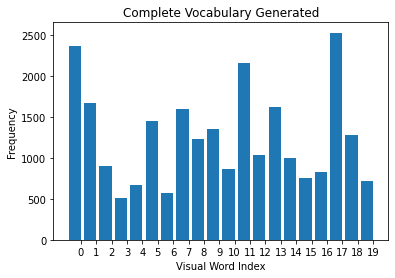

In [22]:
# Plot Trained Vocabulary
def plot_vocab_histogram(vocabulary):
  x_scalar = np.arange(20)
  y_scalar = np.array([abs(np.sum(vocabulary[:,h], dtype=np.int32)) for h in range(20)])

  print(y_scalar)

  plt.bar(x_scalar, y_scalar)
  plt.xlabel("Visual Word Index")
  plt.ylabel("Frequency")
  plt.title("Complete Vocabulary Generated")
  plt.xticks(x_scalar + 0.4, x_scalar)
  plt.show()

plot_vocab_histogram(train_vocab_hist)

In [0]:
# Standardize Histogram
from sklearn.preprocessing import StandardScaler

def standardize(vocab_hist):
  scale = StandardScaler().fit(vocab_hist)
  vocab_hist = scale.transform(vocab_hist)
  return vocab_hist, scale

train_norm_vocab_hist, scale = standardize(train_vocab_hist)

In [24]:
train_labels = np.array(train_labels)
train_norm_vocab_hist.shape, train_labels.shape

((56, 20), (56,))

In [25]:
# Train SVM
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(train_norm_vocab_hist, train_labels)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
# Recognize Each Test Image
def recognize(test_image, sift, kmeans, svm_clf):
  # Compute features of Test Image
  kp, des = sift.detectAndCompute(test_image, None)
  # Create vocabulary
  vocab = np.array( [[ 0 for i in range(20)]])
  test_ret = kmeans.predict(des)
  for each in test_ret:
    vocab[0][each] += 1
  # Scale the image
  vocab = scale.transform(vocab)
  # Predict Class
  im_class = svm_clf.predict(vocab)

  return im_class

In [0]:
# Predictions for Testing Images
predict_labels = []
test_labels = []

for word, image_list in test_dict.items():
  for image in image_list:
    test_labels.append(word_to_id[word])
    label = recognize(image, sift, kmeans, svm_clf)
    predict_labels.append(label)

In [39]:
# Print Test Accuracy
from sklearn import metrics

actual = np.array([id_to_word[label] for label in list(test_labels)])
predicted = np.array([id_to_word[label[0]] for label in list(predict_labels)])

report = metrics.classification_report(y_pred=predicted, y_true=actual)
print(report)

              precision    recall  f1-score   support

 Soccer_Ball       0.00      0.00      0.00         2
   accordion       0.67      1.00      0.80         2
 dollar_bill       0.50      0.50      0.50         2
   motorbike       0.50      0.50      0.50         2

    accuracy                           0.50         8
   macro avg       0.42      0.50      0.45         8
weighted avg       0.42      0.50      0.45         8



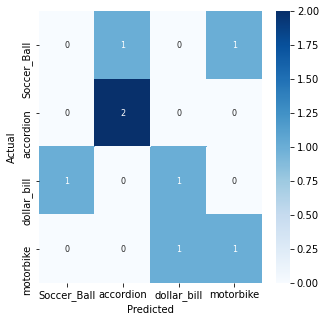

In [42]:
# Confusion Matrix
import seaborn as sns
import pandas as pd

cm = metrics.confusion_matrix(actual, predicted)

df_cm = pd.DataFrame(cm, columns=np.unique(actual), index = np.unique(predicted))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

plt.figure(figsize = (5, 5))
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 8})